# Hotel Reviews Embedding
In this notebook, we train and evaluate a **doc2vec** model to define vectors in an embedding space for reviews from the [hotel reviews dataset](https://www.kaggle.com/datafiniti/hotel-reviews).

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import string, itertools

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from langdetect import detect
from langdetect import DetectorFactory
from nltk.tokenize import word_tokenize
from scipy import stats

DetectorFactory.seed = 0 # enforce deterministic language detection for short / ambiguous text

sns.set()
plt.rcParams['figure.figsize'] = (16, 9)

## Read and examine the data

In [2]:
data = pd.read_csv('./data.csv')

In [3]:
data.shape

(35912, 19)

In [4]:
list(data.columns.values)

['address',
 'categories',
 'city',
 'country',
 'latitude',
 'longitude',
 'name',
 'postalCode',
 'province',
 'reviews.date',
 'reviews.dateAdded',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.rating',
 'reviews.text',
 'reviews.title',
 'reviews.userCity',
 'reviews.username',
 'reviews.userProvince']

In [5]:
data

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN
5,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We loved staying on the island of Lido! You ne...,Very nice hotel,NaN,A Traveler,NaN
6,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-06-10T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Lovely view out onto the lagoon. Excellent vie...,Lovely view out onto the lagoon. Excellent view.,NaN,A Traveler,NaN
7,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-05-14T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,ottimo soggiorno e ottima sistemazione nei gio...,Lovely view out onto the lagoon. Excellent view.,NaN,A Traveler,NaN
8,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-09-14T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,3.0,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,G��nstige Lage,NaN,Doppeldecker,NaN
9,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-05-16T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Lidoen er perfekt til et par dages ro og afsla...,Ro og hygge,NaN,A Traveler,NaN


In [6]:
data['reviews.doRecommend'].value_counts()

Series([], Name: reviews.doRecommend, dtype: int64)

In [7]:
ratings = data['reviews.rating'].value_counts(sort=False).sort_index(ascending=False)

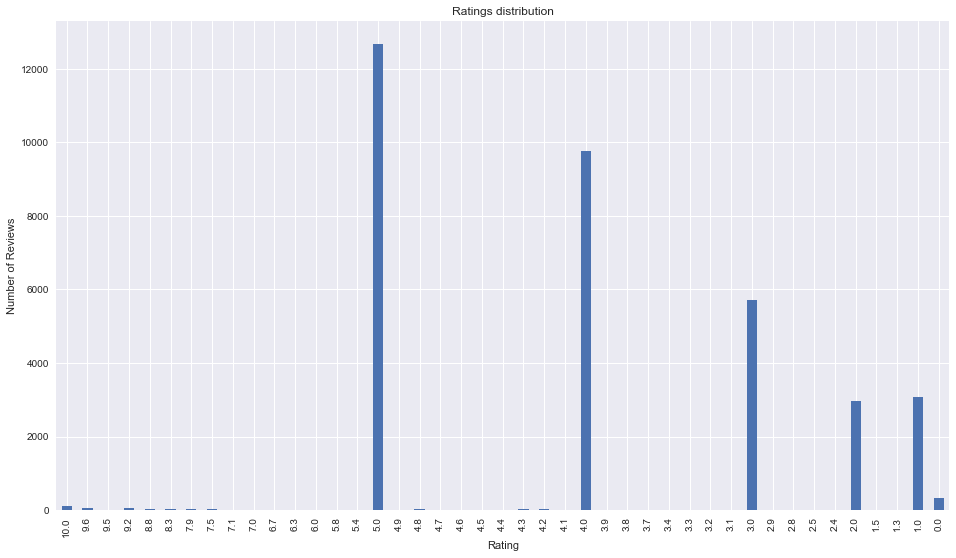

In [8]:
ratings.plot(kind='bar', title='Ratings distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')

## Data cleaning

### Remove dimensions that we will not use
- `reviews.text` + `reviews.title` comprise our input data, $ x $
- `reviews.rating` comprises the ground truth, $ y $.

In [9]:
cleaned = data[['reviews.title', 'reviews.text', 'reviews.rating']].copy()

In [10]:
cleaned.shape

(35912, 3)

In [11]:
cleaned

,reviews.title,reviews.text,reviews.rating
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,4.0
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,5.0
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyge...,5.0
3,Good location on the Lido.,We stayed here for four nights in October. The...,5.0
4,������ ���������������,We stayed here for four nights in October. The...,5.0
5,Very nice hotel,We loved staying on the island of Lido! You ne...,5.0
6,Lovely view out onto the lagoon. Excellent view.,Lovely view out onto the lagoon. Excellent vie...,4.0
7,Lovely view out onto the lagoon. Excellent view.,ottimo soggiorno e ottima sistemazione nei gio...,4.0
8,G��nstige Lage,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,3.0
9,Ro og hygge,Lidoen er perfekt til et par dages ro og afsla...,4.0


### Drop any duplicate reviews
- Considering the `reviews.text` attribute, as we note some exact duplicate review texts above
- Considering the `reviews.title`, since we note reviews with same title above.
    - Some of these may be from different users, however many examples are next to each other in index, so possibly multiple entries from same user? Seems safer to drop them than to attempt a merge

In [12]:
cleaned.drop_duplicates(inplace=True, subset='reviews.text', keep=False)
cleaned.drop_duplicates(inplace=True, subset='reviews.title', keep=False)

In [13]:
cleaned.shape

(16794, 3)

In [14]:
cleaned

,reviews.title,reviews.text,reviews.rating
0,Good location away from the crouds,Pleasant 10 min walk along the sea front to th...,4.0
1,Great hotel with Jacuzzi bath!,Really lovely hotel. Stayed on the very top fl...,5.0
2,Lugnt l��ge,Ett mycket bra hotell. Det som drog ner betyge...,5.0
8,G��nstige Lage,Gnstiger Ausgangspunkt fr Venedig Besuche. Ruh...,3.0
9,Ro og hygge,Lidoen er perfekt til et par dages ro og afsla...,4.0
10,Tr��s bon h��tel calme et agr��able.,"Accueil chaleureux, en franais Changement du l...",4.0
11,It was ok hotel is nice from in and out but room,It was ok hotel is nice from in and out but ro...,3.0
12,Sehr angenehmes Hotel !,"Klasse Frhstck, freundliches und aufmerksames ...",4.0
13,Tip top,"Bardzo sympatyczna obsuga, klimat hotelu. wiet...",4.0
16,Nice hotel with very friendly and helpful staff,"Nice hotel , with very friendly staff and help...",4.0


### Combine the review title and text

In [15]:
cleaned['review'] = cleaned['reviews.title'] + ' ' + cleaned['reviews.text']
cleaned.drop(labels=['reviews.title', 'reviews.text'], inplace=True, axis=1)
cleaned.rename(index=str, columns={'reviews.rating': 'rating'}, inplace=True)

In [16]:
cleaned.head()

,rating,review
0,4.0,Good location away from the crouds Pleasant 10...
1,5.0,Great hotel with Jacuzzi bath! Really lovely h...
2,5.0,Lugnt l��ge Ett mycket bra hotell. Det som dro...
8,3.0,G��nstige Lage Gnstiger Ausgangspunkt fr Vened...
9,4.0,Ro og hygge Lidoen er perfekt til et par dages...


### Drop NaN values
- We will not use data that in not complete

In [17]:
cleaned = cleaned.dropna()

In [18]:
cleaned.shape

(16726, 2)

### Remove noisy ratings
- Vast majority of ratings are one of {1.0, 2.0, 3.0, 4.0, 5.0}.
- Suggests at one point in time the rating scale was 0.0-10.0, but since adjusted to 0-5.
- Therefore, drop any rows with ratings that are not in {1.0, 2.0, 3.0, 4.0, 5.0}

In [21]:
cleaned = cleaned[cleaned['rating'].isin([1.0, 2.0, 3.0, 4.0, 5.0])]

In [22]:
cleaned.shape

(16450, 2)

In [23]:
cleaned['rating'].value_counts()

5.0    6070
4.0    4669
3.0    2686
1.0    1530
2.0    1495
Name: rating, dtype: int64

### Clean the text
- We must lowercase all reviews so that the model is invarient to case
- Remove punctuation and invalid characters

In [24]:
def clean_text(text):
    return text.replace('�', '').lower().translate(str.maketrans('', '', string.punctuation)).strip()

In [25]:
cleaned['review'] = cleaned['review'].apply(clean_text)

### Remove non-English reviews
- For simplicity, in this example we will only consider reviews in one language

In [27]:
def exception_safe_detect(s):
    try:
        return detect(s)
    except:
        return ''

In [28]:
cleaned = cleaned[cleaned['review'].apply(exception_safe_detect) == 'en']

In [29]:
cleaned.shape

(15612, 2)

In [30]:
# Last chance to remove dupes before tokenizing, since lists are unhashable
cleaned.drop_duplicates(inplace=True, keep=False, subset='review')

In [31]:
cleaned.shape

(15600, 2)

### Tokenise the reviews
In order to train the doc2vec model, the reviews must be tokenised into a list of strings.

In [32]:
cleaned['review'] = cleaned['review'].str.split()

In [33]:
cleaned.head()

,rating,review
0,4.0,"[good, location, away, from, the, crouds, plea..."
1,5.0,"[great, hotel, with, jacuzzi, bath, really, lo..."
11,3.0,"[it, was, ok, hotel, is, nice, from, in, and, ..."
16,4.0,"[nice, hotel, with, very, friendly, and, helpf..."
20,1.0,"[dungeons, drain, flies, and, centipedes, dont..."


## Train model
First, we will split the cleaned data into train and test sets, and use these to fit and evaluate a doc2vec model.

In [34]:
x_train, x_test, y_train, y_test = train_test_split(
    cleaned['review'], cleaned['rating'], test_size=0.2, random_state=42)

In [35]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(x_train)]

In [36]:
model = Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [37]:
model.build_vocab(documents)

In [38]:
%time model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 54.8 s, sys: 7.72 s, total: 1min 2s
Wall time: 30.6 s


### Sanity check
Check the similarity ranks for documents from the training set. If the model is working properly, the query document should be ranked 0th in the similarity results.

In [39]:
ranks = []

for i in range(len(x_train)):
    inferred_vector = model.infer_vector(x_train.iloc[i])
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    ranks.append([docid for docid, _ in sims].index(i))

/Users/rtjfarrimond/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


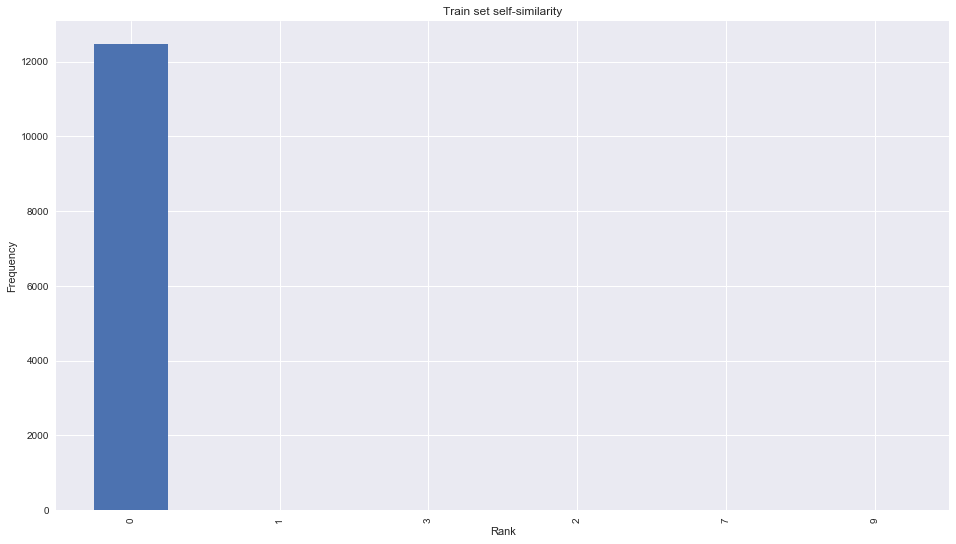

In [40]:
pd.Series(ranks).value_counts().plot('bar')
plt.title('Train set self-similarity')
plt.xlabel('Rank')
plt.ylabel('Frequency')

## Evaluate the model
We will evaluate our doc2vec model by defining a prediction $ \hat{y} $ to be the modal rating for the 10 most similar results to each document in the train and test sets. Once we have computed $ \hat{y} $, we will compare how it compares with the ground truth by visualising a confusion matrix.

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap='coolwarm'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
def inspect_ratings(x, y, docvec_labels):
    ratings = {}
    
    for i in range(len(x)):
        inferred_vector = model.infer_vector(x.iloc[i])
        rating = [docvec_labels[idx] for idx, _ in model.docvecs.most_similar([inferred_vector], topn=10)]
        ratings[i] = rating
        
    conf_mat = confusion_matrix(y.values, [stats.mode(v)[0][0] for v in ratings.values()])
        
    return ratings, conf_mat

In [44]:
train_ratings, train_conf = inspect_ratings(x_train, y_train, y_train)
test_ratings, test_conf = inspect_ratings(x_test, y_test, y_train)

/Users/rtjfarrimond/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


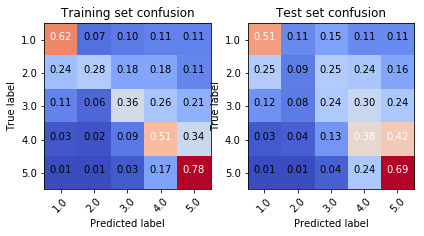

In [45]:
sns.reset_orig()

plt.subplot(1,2,1)
plot_confusion_matrix(train_conf, np.unique(y_train), normalize=True, title='Training set confusion')
plt.subplot(1,2,2)
plot_confusion_matrix(test_conf, np.unique(y_test), normalize=True, title='Test set confusion')

In [41]:
model.save('doc2vec.mdl')